In [1]:
import numpy as np
from tqdm import tqdm
from utils import *
from utils_data import *
import argparse
import os
import random
random.seed(0)

from models import Glow
from models.glow.coupling import UNet1
import util
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.backends.cudnn as cudnn

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--mode', type=str, default='petgc')
parser.add_argument('--noise_level', type=list, default=[20]) # For PET-CT, noise_level = [PET, CT]
parser.add_argument('--semi_sup', type=bool, default=True)
parser.add_argument('--supervision', type=float, default=0.0)
parser.add_argument('--secondary_noisy', type=bool, default=False)
parser.add_argument('--resume_training', type=int, default=0)
parser.add_argument('--train_size', type=int, default=800)
parser.add_argument('--blur_mode',type=str, default=None)
parser.add_argument('--new_range',type=int, default=2)

parser.add_argument('--transfer_learning', type=bool, default=False)
parser.add_argument('--transfer_path', type=str, default='../results200_nd/unet_var_multi5/e3sgdws_petct_bpetnoperc_unet_var_ggg_multif_semi_0.0005-5000_0.5/model_400.ckpt')

parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--epoch_num', type=int, default=500)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--device', type=str, default='cuda:2')
parser.add_argument('--weights',type=tuple,default=[1, 1, 1]) #(pet, ct, latent)

parser.add_argument('--save', type=bool, default=True)
parser.add_argument('--path', type=str, default='../results/e3adam_')
parser.add_argument('--save_path', type=str, default='')
parser.add_argument('--save_path_fig', type=str, default='')

parser.add_argument('--num_levels', '-L', default=4, type=int, help='Number of levels in the Glow model')
parser.add_argument('--num_steps', '-K', default=8, type=int, help='Number of steps of flow in each level')
parser.add_argument('--cc', type = bool, default = False)
parser.add_argument('--warm_up', default=500000, type=int, help='Number of steps for lr warm-up')
parser.add_argument('--ext', default = 'll', type=str)

args = parser.parse_args(args=[])
# args_check(args)

In [3]:
trainloader, testloader, validloader = load_data(args)

(800, 1, 256, 256) (433, 1, 256, 256)
same used


In [4]:
args = create_save_path(args)

../results/e3adam_petgc_same_semi_20_0.0
Create path : ../results/e3adam_petgc_same_semi_20_0.0


In [5]:
net = Glow(num_channels=128,
               num_levels=args.num_levels,
               num_steps=args.num_steps,
               inp_channel=1,
               cond_channel=1,
               cc = args.cc)
net = net.to(args.device)
cudnn.benchmark = True
# if device == 'cuda':
#     net = torch.nn.DataParallel(net, args.gpu_ids)
#     cudnn.benchmark = args.benchmark

if args.resume_training!=0:
    net.load_state_dict(torch.load(args.save_path+'/model_'+str(args.resume_training)+'.ckpt', map_location='cpu'))

unet = UNet1(inp_channels=1, op_channels=1)
unet = unet.to(args.device)
# unet_weights = torch.load('ckpts/unet/best.pth', map_location = args.device)
# unet.load_state_dict(unet_weights)

In [6]:
@torch.enable_grad()
def train(epoch, net, data_loader, device, optimizer, loss_fn, args = None, max_grad_norm = -1, model = None, valid=False):
    global global_step
    global_step = 0
    net.train()
    latent_loss_m = []
    spatial_loss_m = util.AverageMeter()

    for i, x_prime in enumerate(data_loader):
        x = x_prime[0] #x_prime[:, idx1, :, :]
        cond_x = x_prime[1] #x_prime[:, idx2, :, :]
        if len(x.shape) < 4:
            x = x.unsqueeze(1)
        if len(cond_x.shape) < 4:
            cond_x = cond_x.unsqueeze(1)
        x, cond_x = x.to(device), cond_x.to(device)
        z, sldj = net(x, cond_x, reverse=False)
        
        if valid==True:
            latent_loss = loss_fn(z, sldj)
            latent_loss_m.append(latent_loss.item())
        else:
            if args.ext == 'll+sl_pl' or args.ext == 'll+sl_l1':
                ;
            elif args.ext == 'll':
                optimizer.zero_grad()
                latent_loss = loss_fn(z, sldj)
                latent_loss.backward()
                if max_grad_norm > 0:
                    util.clip_grad_norm(optimizer, max_grad_norm)
                optimizer.step()

                latent_loss_m.append(latent_loss.item())
        
    return sum(latent_loss_m) / len(latent_loss_m)

In [7]:
if args.mode=='ct':
    k = 2524
elif args.mode=='pet':
    k = 46000
elif args.mode=='petgc':
    k = 65535
loss_fn = util.NLLLoss(k).to(args.device)

if 'sgd' in args.path:
    optimizer = torch.optim.SGD(net.parameters(), lr=args.lr)
elif 'adam' in args.path:
    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
    
epoch = args.resume_training
train_loss = valid_loss = []

with tqdm(total = (args.epoch_num-args.resume_training), desc = "Epoch") as progress_bar:
    while epoch < args.epoch_num:
        loss = train(epoch, net, trainloader, args.device, optimizer, loss_fn, args)

        progress_bar.set_postfix(nll=loss, lr=optimizer.param_groups[0]['lr'])
        progress_bar.update(1)

        if epoch%5==0:
            train_loss.append(loss)
            loss = train(epoch, net, validloader, args.device, optimizer, loss_fn, args, valid=True)
            valid_loss.append(loss)

        if (epoch+1)%25==0 and args.save:
            #save checkpoint
            torch.save(net.state_dict(), args.save_path+'/model_'+str(epoch+1)+'.ckpt')

        epoch += 1

Epoch: 100%|██████████| 500/500 [12:01:42<00:00, 86.60s/it, lr=0.001, nll=3.83e+5]  


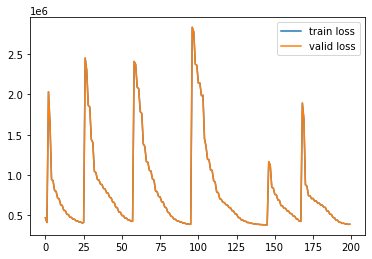

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train loss')
plt.plot(valid_loss, label='valid loss')
# plt.ylim(0,2e9)
# plt.xlim(100,120)
plt.legend()

if args.save and args.resume_training==0:
    plt.savefig(args.save_path+'/loss.png')
elif args.save and args.resume_training!=0:
    plt.savefig(args.save_path+'/loss_'+str(args.resume_training)+'.png')
    
plt.show()

In [9]:
errors = test_model(args,net,testloader)
print(np.median(errors,0))

  0%|          | 0/433 [00:01<?, ?it/s]


UnboundLocalError: local variable 'trunc_min' referenced before assignment

In [ ]:
print(np.median(errors,0))